In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
#import cv2
import types
import random

from utils import *

In [16]:
WIDTH = 384
HEIGHT = 128
SZ = 224
BS = 64
NUM_WORKERS = 6

In [2]:
root_dir = Path('../input')
train_dir = root_dir/'train'
old_train_dir = root_dir/'old/train'
bg_dir = root_dir/'sea'
annot_dir = root_dir/'annotation'
learn_path = Path('../')
crop_dir = root_dir/'crop'

In [3]:
def relative_path(original_path, relative_to=root_dir):
    return pathlib.PurePath(original_path).relative_to(relative_to)

For old train data

In [4]:
def points2bbox(points):
    left, top = points[0]
    right, bottom = points[0]
    for x, y in points[1:]:
        left = min(left, x)
        top = min(top, y)
        right = max(right, x)
        bottom = max(bottom, y)
    return [top, left, bottom, right]


In [5]:
annot_dir.ls()

[PosixPath('../input/annotation/sloth_config.py'),
 PosixPath('../input/annotation/annotations.json'),
 PosixPath('../input/annotation/cropping.txt'),
 PosixPath('../input/annotation/val_fns_detection.pkl'),
 PosixPath('../input/annotation/.python-version'),
 PosixPath('../input/annotation/sloth_config.pyc'),
 PosixPath('../input/annotation/.blank')]

In [6]:
with open(annot_dir/'cropping.txt', 'rt') as f: 
    data = f.read().split('\n')[:-1]
len(data) # Number of rows in the dataset

1200

In [7]:
for line in data[:5]: 
    print(line)

88532e70.jpg,195,293,269,115,868,158,888,170,641,496,512,546,321,524
0c88a7aa.jpg,125,78,159,19,784,19,808,95,457,390
1442f41d.jpg,19,112,58,13,618,19,652,50,418,276,99,247
1b5f7f86.jpg,109,347,124,309,906,298,933,355,591,483,454,494
2cb0e816.jpg,38,230,77,193,950,198,990,245,705,469,513,484,343,443


In [8]:
data = [line.split(',') for line in data]
old_annot = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in data]
old_annot[0] # First row of the dataset

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [9]:
old_annot[0][-1][0]

(195, 293)

In [10]:
# check if the files exist
for fn, _ in old_annot:
    if not os.path.isfile(old_train_dir/fn):
        print(fn)

In [11]:
old_fn2bbox = {relative_path(old_train_dir/anno[0]): [[points2bbox(anno[1])], ['fluke']] for anno in old_annot}

In [12]:
img = open_image(old_train_dir/old_annot[0][0])
#bbox = old_anno2bbox(old_annot[0])
brect = points2bbox(old_annot[0][1])
print(img.size, brect)
bbox = ImageBBox.create(img.size[0], img.size[1], [brect])

torch.Size([700, 1050]) [115, 195, 546, 888]


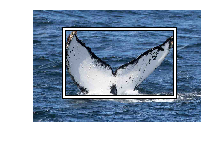

In [13]:
img.show(y=bbox)

For new train data

In [14]:
new_annot = json.load(open(f'{annot_dir}/annotations.json'))

In [15]:
new_annot[0]

{'annotations': [{'class': 'fluke',
   'height': 372.0,
   'type': 'rect',
   'width': 1017.0,
   'x': 14.0,
   'y': 97.0},
  {'class': 'left',
   'type': 'point',
   'x': 50.802273527488566,
   'y': 98.58659021176},
  {'class': 'notch',
   'type': 'point',
   'x': 516.2391276137811,
   'y': 269.48861474128864},
  {'class': 'right',
   'type': 'point',
   'x': 1013.5305065138045,
   'y': 102.10753986218477}],
 'class': 'image',
 'filename': '6138dce83.jpg'}

The above annotations are in coco dataset format (x, y, width, height). The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [17]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"../input/train/{anno['filename']}").size
    file = anno['filename']
    for anno in anno['annotations']:
        if anno['class'] == 'fluke':
            break
    #anno = anno['annotations'][0]
    #print(file, anno)
    return [
        #np.clip(anno['y'], 0, im_height) / im_height * SZ,
        #np.clip(anno['x'], 0, im_width) / im_width * SZ,
        #np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        #np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ

        np.clip(anno['y'], 0, im_height),
        np.clip(anno['x'], 0, im_width),
        np.clip(anno['y']+anno['height'], 0, im_height),
        np.clip(anno['x']+anno['width'], 0, im_width)
    ]

Just some small functions that will be helpful as we construct our dataset.

In [18]:
fn2bbox = {relative_path(root_dir/'train'/jj['filename']): [[anno2bbox(jj)], ['fluke']] for jj in new_annot}

#merge old and new 
fn2bbox.update(old_fn2bbox)


In [19]:
get_y_func = lambda o: fn2bbox[relative_path(o)]

In [20]:
len(fn2bbox)

1600

In [25]:
width, height = 0, 0
print(len(fn2bbox))
for _, item in fn2bbox.items():
    top, left, bottom, right = item[0][0]
    width += right - left
    height += bottom - top
print(f'aerage width: {width//len(fn2bbox)}, average height: {height//len(fn2bbox)}, ratio = {width / height}')

1600
aerage width: 880.0, average height: 286.0, ratio = 3.0753389533131865


In [26]:
n_val = 300
fn_list = list(fn2bbox.keys())
random.seed(0)
random.shuffle(fn_list)
val_fns = fn_list[:n_val]
trn_fns = fn_list[n_val:]

In [27]:
val_fns[0]

PurePosixPath('old/train/c56c7109.jpg')

ObjectCategoryList is designed to be used in a full object recognition scenario (multiple bounding boxes per image, objects of multiple classes). Since that is more functionality than we require (and more than our model will predict - our objects will always be of the same class, fluke, and we will be predicting just a single bounding box per image) I make minor changes to ObjectCategoryList.

In [24]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [37]:
data = (ImageItemList
        .from_folder(train_dir)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
       )

data

AttributeError: 'ImageItemList' object has no attribute 'add_test'

In [33]:
data = (ImageItemList
        .from_folder(train_dir)
        .no_split()
        #split_by_valid_func(lambda path: relative_path(path) in val_fns)
        #.split_by_valid_func(val_func)
        #.label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        #.transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.5, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .add_test(ImageItemList.from_folder(test_path))
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))


AttributeError: 'ImageItemList' object has no attribute 'add_test'

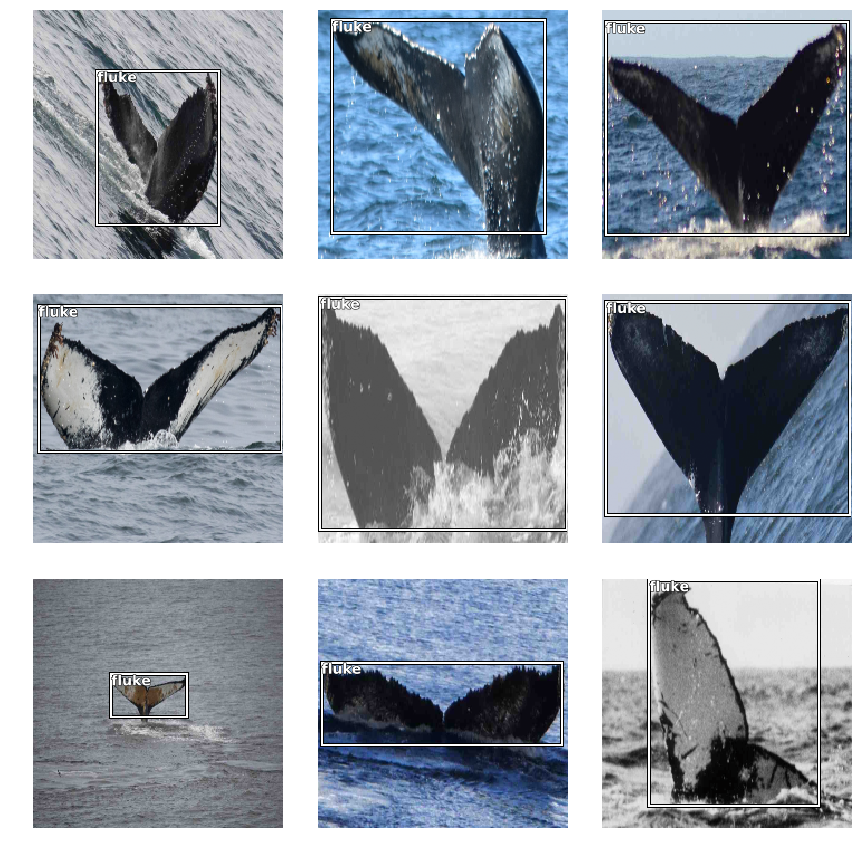

In [26]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [27]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [28]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [29]:
iou = partial(dice, iou=True)

In [30]:
dice

<function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False) -> <function NewType.<locals>.new_type at 0x7f5ece0e1d08>>

In [31]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn, path=learn_path)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [32]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.recorder.plot_losses()

In [33]:
learn.unfreeze()

In [34]:
max_lr = 3e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [35]:
from fastai.callbacks import *
cb_save_model = SaveModelCallback(learn, monitor='val_loss', every="epoch", name=f"fluke_location")
cb_early_stopping = EarlyStoppingCallback(learn, monitor='val_loss', min_delta=1e-3, patience=15)
cbs = [cb_save_model, cb_early_stopping]

In [36]:
learn.load('fluke_location')

Learner(data=ImageDataBunch;

Train: LabelList
y: StubbedObjectCategoryList (1300 items)
[ImageBBox (500, 703), ImageBBox (405, 1050), ImageBBox (398, 700), ImageBBox (329, 1050), ImageBBox (235, 819)]...
Path: ../input
x: ObjectItemList (1300 items)
[Image (3, 500, 703), Image (3, 405, 1050), Image (3, 398, 700), Image (3, 329, 1050), Image (3, 235, 819)]...
Path: ../input;

Valid: LabelList
y: StubbedObjectCategoryList (300 items)
[ImageBBox (700, 1050), ImageBBox (450, 1050), ImageBBox (446, 1050), ImageBBox (600, 1050), ImageBBox (254, 1050)]...
Path: ../input
x: ObjectItemList (300 items)
[Image (3, 700, 1050), Image (3, 450, 1050), Image (3, 446, 1050), Image (3, 600, 1050), Image (3, 254, 1050)]...
Path: ../input;

Test: None, model=FlukeDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool

In [37]:
learn.fit_one_cycle(100, lrs, div_factor=20, callbacks=cbs)

epoch,train_loss,valid_loss,
1,0.033864,0.025747,0.922480
2,0.032751,0.025374,0.922431
3,0.033057,0.025549,0.921908
4,0.032702,0.027412,0.915245
5,0.031931,0.026236,0.919680
6,0.032063,0.026005,0.921491
7,0.031914,0.025835,0.922429
8,0.032156,0.025309,0.924604
9,0.032027,0.026716,0.918688
10,0.032281,0.026307,0.920607


Epoch 30: early stopping


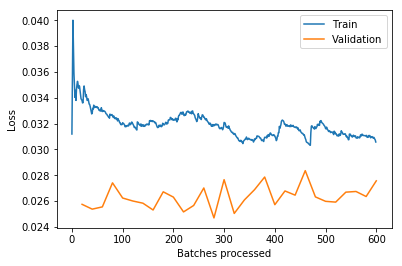

In [38]:
learn.recorder.plot_losses()

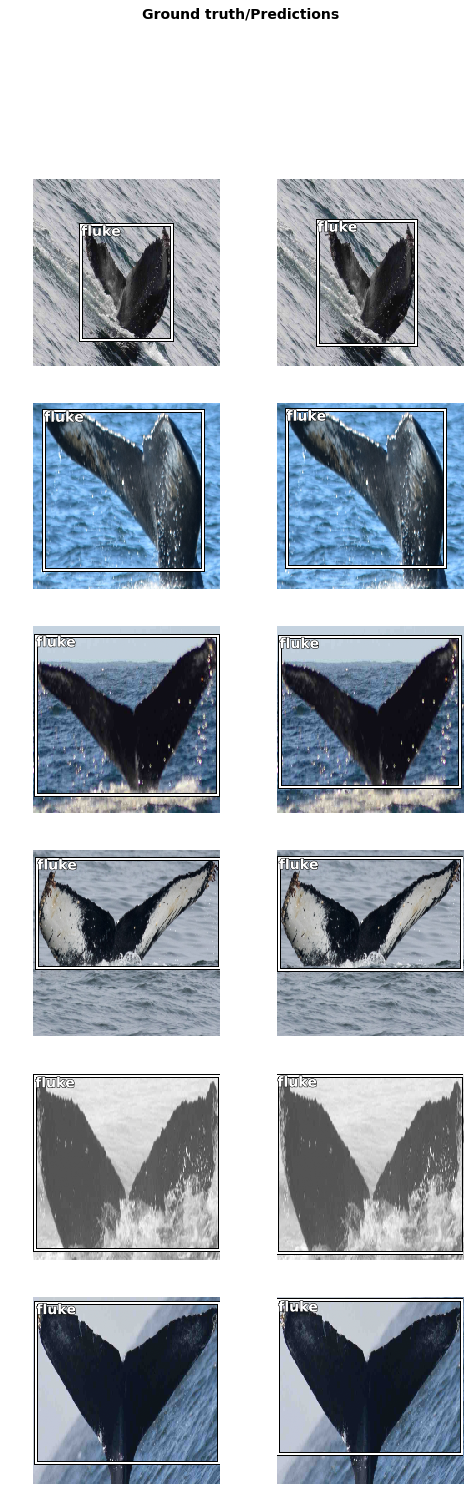

In [39]:
learn.show_results(rows=6)

In [ ]:
# preds, targs = learn.get_preds()

# predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
# targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

# def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
#     y_min, x_min, y_max, x_max = map(int, bbox)
#     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
#     if target is not None:
#         y_min, x_min, y_max, x_max = map(int, target)
#         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
#     return img

# def cv_read(path):    
#     im = cv2.imread(path, cv2.IMREAD_COLOR)
#     return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# # Targets are in green, predictions in red.
# ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
# plt.figure(figsize=(12,12))
# plt.axis('off')
# plt.imshow(montage(np.stack(ims), multichannel=True))